# Assignment: Principal Component Analysis on SST Data

1. figure out how to compute and access the first eigenvector (called Principal Component) using sklearn's PCA
2. Plot and interpret this eigenvector from what you have learnt in previous climate science courses.
3. Project each individual month's data onto this eigenvector and form a time series and plot it.
4. Interpret what this time series means.

---------------------------------------

# 1. Setting up the data (like before):

Importing necessary libraries for this notebook:

In [2]:
import xarray
import matplotlib.pyplot as plt
import numpy as np

Reading the Dataset file:

In [3]:
complete_raw_sst = xarray.open_dataset('test.nc', engine='scipy').sst

Preparing our datasets (just like for the KMeans Clustering Assignment)

In [4]:
raw_selected_SST = complete_raw_sst[1000::, :].load()
# SELECTED SUBSET OF DATA THAT IS MORE RELIABLE - POST THE 1000TH MONTH

raw_selected_SST_monthly_means = raw_selected_SST.groupby('time.month').mean()
# MONTHLY MEAN FOR EVERY MONTH OVER THE SELECTED YEARS

# WE SUBSTRACT THE CORRESPONDING MONTHLY MEAN SST FROM EACH DATAPOINT
# THIS WILL GIVE US THE 'MONTHLY ANOMALIES' ACROSS ALL DATAPOINTS, AS DEFINED BELOW
anomalies = raw_selected_SST.groupby('time.month') - raw_selected_SST_monthly_means

In [5]:
cosines_of_latitudes = np.cos(np.deg2rad(raw_selected_SST.coords['lat'].values))
# 1D ARRAY OF THE COSINES OF ALL LATITUDES FROM -88 TO 88 DEGREES, STEP_SIZE=2
latitude_weights = np.tile(cosines_of_latitudes, (len(complete_raw_sst.lon), 1)).transpose()
# 2D MATRIX CONSTRUCTED BY TILING THE 1D ARRAY FOR EACH LONGITUDE
weights = np.tile(latitude_weights, (len(raw_selected_SST.time), 1, 1))
# COSINE WEIGHTS FOR THE DATASET CONSTRUCTED BY TILING THE ABOVE 2D MATRIX FOR EACH TIMEPOINT

weighted_zero_mean_anomalies = anomalies - (anomalies*weights).mean(dim=['lat', 'lon'])
'''COSINE-WEIGHTED TIME-ANOMALIES'''
weighted_SST = raw_selected_SST*weights
'''COSINE-WEIGHTED RAW DATA'''

SST_with_nan = weighted_SST[0,:,:]
# GENERATING THIS SEPARATELY - USEFUL LATER FOR REINTRODUCING NaN VALUES POST-CLUSTERING

Filling in the empty/NaN values with -1000:

In [6]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values=np.nan,strategy="constant",fill_value=-1000)
# FUNCTION FROM SCIKIT-LEARN THAT IS USED TO FILL IN MISSING VALUES IN DATASETS

for i in range(572):
# REPLACING THE NULL VALUES FOR ONE TIME-STAMP AT A TIME
    weighted_SST[i,:,:] = imputer.fit_transform(weighted_SST[i,:,:])
    # REPLACING NANS WITH -1000 FOR THE SST VALUES
    weighted_zero_mean_anomalies[i,:,:] = imputer.fit_transform(weighted_zero_mean_anomalies[i,:,:])
    # REPLACING NANS WITH -1000 FOR THE ANOMALIES

Reshaping the xarray into a numpy array for use in the PCA function:

In [7]:
sst_np_array = (weighted_zero_mean_anomalies*weights).fillna(0).values.reshape(572, 89*180)

## 2. Carrying out the PCA:

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
#WE INITIALISE THE PCA, SPECIFYING HOW MANY COMPONENTS WE WOULD LIKE
pca.fit(sst_np_array)
#PCA MODEL FITTED TO OUR DATA
pca.components_

first_eigenvector = pca.components_[0]
#THIS IS THE FIRST PRINCIPAL COMPONENT, AKA THE FIRST EIGENVECTOR!!!


Reshaping the numpy array back into the format of an xarray and subsequently plotting:

In [9]:
first_eigenvector_in_2D = first_eigenvector.reshape((1, 89, 180))

<Figure size 640x480 with 0 Axes>

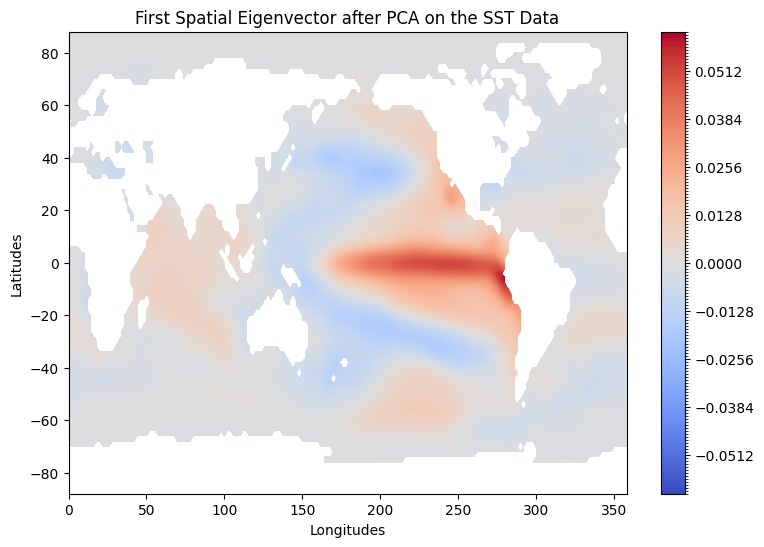

In [25]:
%matplotlib inline
plt.clf()

dims = weighted_SST.dims
#DIMENSIONS OF THE ORIGINAL DATASET WE USED AS INPUT
coords = {'time': [0],'lat': weighted_SST.coords['lat'],'lon': weighted_SST.coords['lon'],}
#COORDINATE SETS OF THE ORIGINAL DATASET WE USED AS INPUT
first_eigenvector_xarray = xarray.DataArray(first_eigenvector_in_2D, dims=dims, coords=coords)
#RESHAPING THE NUMPY ARRAY INTO AN XARRAY FORMAT

first_eigenvector_xarray = first_eigenvector_xarray.astype(float)
first_eigenvector_xarray.values[0,:,:] = np.where(SST_with_nan==-1000, np.nan, first_eigenvector_xarray.values[0,:,:])
#REINTRODUCING NAN VALUES BY COMPARING THE DATA WITH A SLICE FROM THE EARLIER SELECTED DATASET

plt.figure(figsize=(9,6))
cs = first_eigenvector_xarray.sel(time=0).plot.contourf(cmap="coolwarm",levels=200,robust=False)
#PLOTTING THE FIRST SPATIAL EIGENVECTOR
plt.title(f"First Spatial Eigenvector after PCA on the SST Data")
plt.xlabel("Longitudes")
plt.ylabel("Latitudes")
plt.grid(False)
plt.show()
#plt.savefig('First Eigenvector Regular Plot',dpi=300)

## 3. Analysis of the time series after projection:
Projecting each month-vector onto the first Eigenvector by means of a dot-product, and then plotting the same as a resultant time-series:

C:\Users\lokes\AppData\Local\Temp\ipykernel_12924\615177306.py:11: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, '360_day', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  time = weighted_SST.indexes['time'].to_datetimeindex()


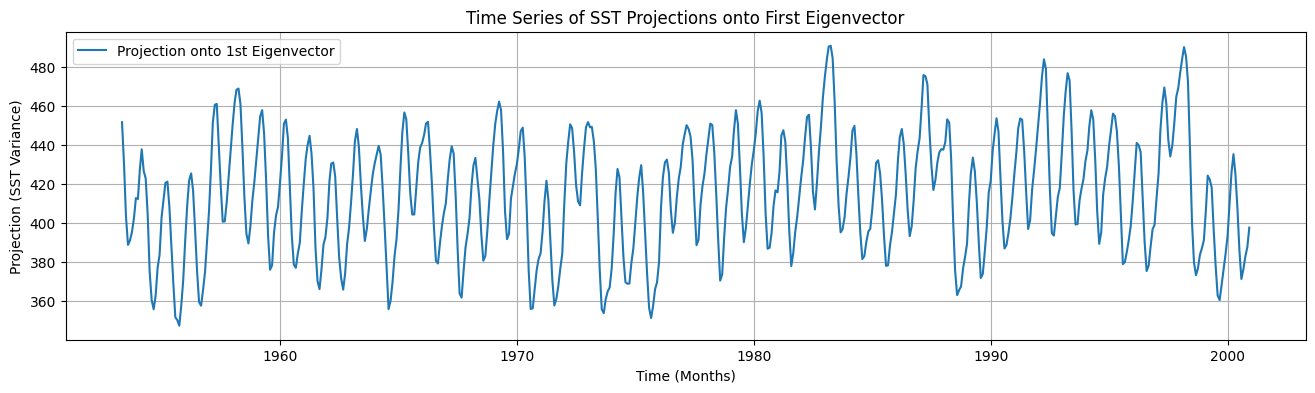

In [11]:
%matplotlib inline

sst_flattened = weighted_SST.values.reshape(weighted_SST.shape[0], weighted_SST.shape[1]*weighted_SST.shape[2])
eigenvector_flattened = first_eigenvector.reshape(-1)
#FLATTENING AND RESHAPING THE XARRAY INTO A 1-DIMENSIONAL ARRAY

projections = np.dot(sst_flattened, eigenvector_flattened)
#PROJECTING EACH MONTH ONTO THIS EIGENVECTOR

# WE CONVERT THE cftime DATAFORMAT TO datetime64 TO AVOID ERRORS
time = weighted_SST.indexes['time'].to_datetimeindex()

plt.figure(figsize=(16, 4))
plt.plot(time, projections, label="Projection onto 1st Eigenvector")
plt.title("Time Series of SST Projections onto First Eigenvector")
plt.xlabel("Time (Months)")
plt.ylabel("Projection (SST Variance)")
plt.grid(True)
plt.legend()
plt.show()
#plt.savefig('Eigenvector projection time series',dpi=300)

Since the time-series data looks messy and doesn't exactly give us a picture of what is happening, we use some functions from SciPy in finding the 'average' of these oscillatory patterns, by means of a moving window function that is as defined below.

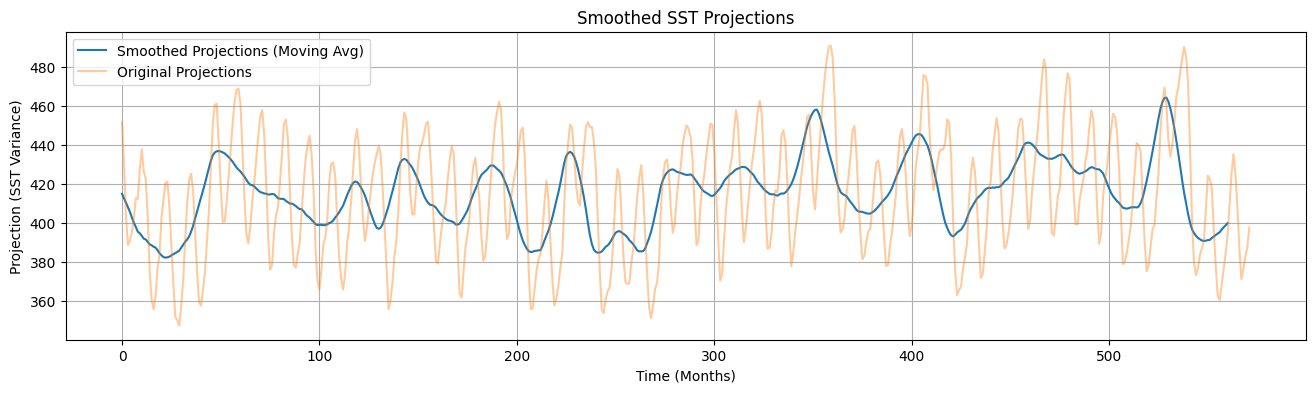

In [15]:
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks
%matplotlib inline

# WE DEFINE A MOVING AVERAGE FUNCTION IN ORDER TO LOOK AT ONLY THE AVERAGES OF THIS DATA BY MEANS OF CONVOLOUTION WITH A WINDOW_SIZE = 12 MONTHS
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

window_size = 12 #THIS GIVES US OUR TWELVE-MONTH MOVING AVERAGE
smoothed_projections = moving_average(projections, window_size)

#PLOTTING BOTH THE TIME-SERIES AS WELL AS THE SMOOTHENED 'AVERAGE' CURVE
plt.figure(figsize=(16, 4))
plt.plot(time[:len(smoothed_projections)], smoothed_projections, label='Smoothed Projections (Moving Avg)')
plt.plot(time, projections, alpha=0.4, label='Original Projections')
plt.xlabel('Time (Months)')
plt.ylabel('Projection (SST Variance)')
plt.title('Smoothed SST Projections')
plt.grid(True)
plt.legend()
plt.show()
#plt.savefig('Eigenvector projection time series with mean line',dpi=300)

To identify which months and years the peaks correspond to, we use the below snippet.

In [24]:
start_year = 1953
start_month = 1
total_months = len(projections)

time = np.arange(total_months)
years = start_year + time // 12
months = start_month + time % 12

peaks, _ = find_peaks(smoothed_projections)

for peak in peaks:
    print(f"Peak in {years[peak]}")

Peak in 1957
Peak in 1959
Peak in 1961
Peak in 1962
Peak in 1964
Peak in 1968
Peak in 1971
Peak in 1974
Peak in 1976
Peak in 1977
Peak in 1979
Peak in 1980
Peak in 1980
Peak in 1982
Peak in 1986
Peak in 1989
Peak in 1989
Peak in 1989
Peak in 1991
Peak in 1992
Peak in 1992
Peak in 1993
Peak in 1995
Peak in 1997


## 4. Conclusions:

The peaks that we see in the moving average line (the blue curve) represent the periods of months that experienced the ENSO Phenomenon. This may be compared with an actual analysed plot taken from Wikipedia of which years faced El Nino:

![El Nino events timeline.jpg](<attachment:El Nino events timeline.jpg>)
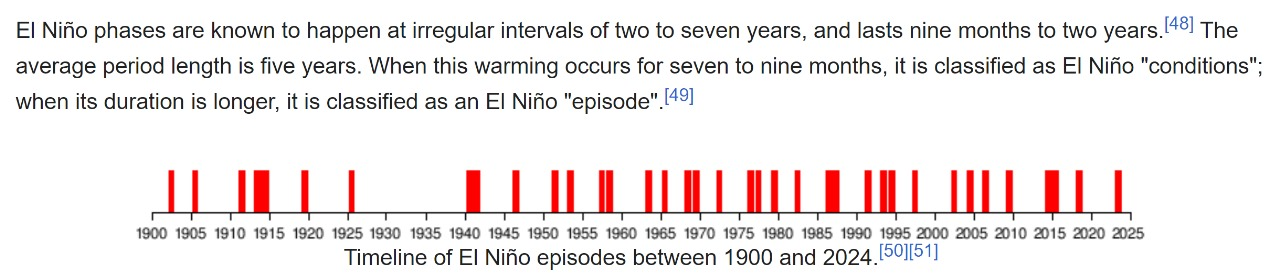

When compared, the moving average plot shows reasonable consistency with the data represented by this image from Wikipedia. The first Eigenvector plotted, too shows the El Nino phenomenon with extremely high temperatures in the eastern part of the Pacific. It is therefore expected, that the 'dot product' will be maximum for those vectors that are 'similar' to the El Nino Eigenvector, and therefore those months (and years) are El Nino years.